# Simple demo of three, single-component envs in a multi-agent env

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gridworld import ComponentEnv
from gridworld import MultiAgentEnv
from gridworld.distribution_system import OpenDSSSolver
from gridworld.agents.vehicles import EVChargingEnv

%matplotlib inline

[WARNING] multiagent_env.py:17: rllib MultiAgentEnv not found, using generic object class


In [2]:
# Configuration for the single-component agents (in this case, identical
# except for names).
agents = [
    {
        "name": "ev-charging-{}".format(i),
        "bus": "675c",
        "cls": EVChargingEnv,
        "config": {
            "num_vehicles": 100,
            "minutes_per_step": 5,
            "max_charge_rate_kw": 7.,
            "peak_threshold": 250.,
            "vehicle_multiplier": 2.,
            "rescale_spaces": False
        }
    } for i in range(3)
]

# Bare minimum common config specifies start and stop times, and control
# timedelta.  
common_config = {
    "start_time": "08-12-2020 00:00:00",
    "end_time": "08-13-2020 00:00:00",
    "control_timedelta": pd.Timedelta(300, "s")
}

# PowerFlow configuration.  Note that file paths are relative to 
# "gridworld/distribution_system/data" by default.
pf_config = {
    "cls": OpenDSSSolver,
    "config": {
        "feeder_file": "ieee_13_dss/IEEE13Nodeckt.dss",
        "loadshape_file": "ieee_13_dss/annual_hourly_load_profile.csv",
        "system_load_rescale_factor": 0.8,
    }
}

# Configuration of the multi-agent environment.
env_config = {
    "common_config": common_config,
    "pf_config": pf_config,
    "agents": agents
}

# Create the env and run an episode using random policy

In [3]:
env = MultiAgentEnv(**env_config)
env.reset()
done = {"__all__": False}
metas = []
states = []
while not done["__all__"]:
    action = {name: space.sample() for name, space in env.action_space.items()}
    obs, rew, done, meta = env.step(action)
    states.append(obs)
    metas.append(meta)

### Plot voltages

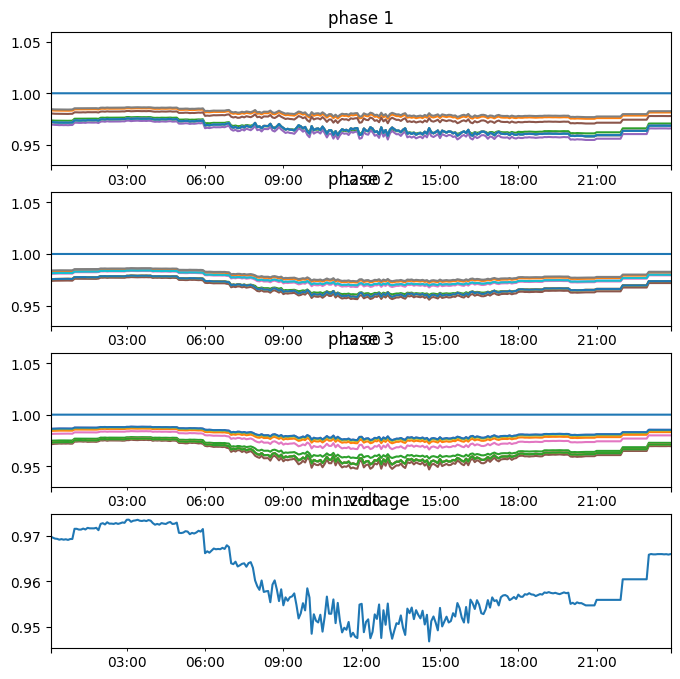

In [4]:
df = pd.DataFrame(env.history["voltage"], index=env.history["timestamp"])

fig, ax = plt.subplots(4)
fig.set_size_inches((8, 8))
for i in range(3):
    _ = df[[x for x in df.columns if x.startswith("6") and x.endswith(str(i+1))]].plot(
        ax=ax[i], legend=False, ylim=(0.93, 1.06), title="phase " + str(i+1))

_  = df.min(axis=1).plot(title="min voltage", ax=ax[i+1])